This file is posted, to show another approach to obtain tiff files. Geopunt is the database where you can find the files needed to obtain the elevation of the buildings in Flanders. Many databases with geographic information provide other options for downloading their data. It can be an extension for Qgis or Arcgis(GIS Software), an API or an OWS (Open Geospatial Consortium (OGC) Web Services (OWS)).

I have only been able to access WMS, this method allows to obtain an image of the desired information in the selected area. The image would only serve to display it, not to obtain elevation data. To obtain the real elevation data it would be necessary to resort to a WCS, but at the date of publication, it has not been possible to extract this information. 



In [1]:
import requests
import json
import rasterio as rio
import rioxarray as rxr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import earthpy.plot as ep
import seaborn as sns
import plotly.graph_objects as go

#Two new packages
from pyproj import Transformer
from owslib.wms import WebMapService

In [2]:
street='A. Verbouwelaan'
number='15'
post='8670'

In [3]:
polygone=[]

In [4]:
def house_info(street, number, post):
    a=requests.get('https://api.basisregisters.dev-vlaanderen.be/v1/adressen?'+'straatnaam='+street+'&huisnummer='+number+'&postcode='+post+'&limit=1')
    b=a.json()
    id1= b['adressen'][0]['identificator']['objectId']
    print('Address found: Id1 is',id1)
    c=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden?adresObjectId='+id1)
    d=c.json()
    id2= d['gebouweenheden'][0]['identificator']['objectId']
    print('Building units found: Id2 is',id2)
    e=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouweenheden/'+id2)
    f=e.json()
    id3= f['gebouw']['objectId']
    print('Building found: Id3 is',id3)
    g=requests.get('https://api.basisregisters.vlaanderen.be/v1/gebouwen/'+id3)
    h=g.json()
    poly=h['geometriePolygoon']['polygon']['coordinates'][0]
    polygone.append(poly)

In [5]:
house_info(street, number, post)

Address found: Id1 is 20074984
Building units found: Id2 is 20074995
Building found: Id3 is 16145178


### To select the bounderis to look for in the WMS, we select the min x and y and the max x and y inside the poligone. 

In [6]:
all_x=[]
all_y=[]

In [7]:
for p in polygone:
    for i in p:
        first_item=i[0]
        all_x.append(first_item)
        second_item=i[1]
        all_y.append(second_item)

### Bounderies in Lambert

In [8]:
bounds_coord=min(all_x), min(all_y), max(all_x), max(all_y)

In [9]:
bounds_coord

(28128.95103101432, 201356.1280137822, 28178.24491904676, 201404.19233381748)

### Transform from x y coordinates to LONG and LAT

In [10]:
transformer = Transformer.from_crs(31370,4326)

In [11]:
b, a = transformer.transform(bounds_coord[0], bounds_coord[1])

In [12]:
d, c = transformer.transform(bounds_coord[2], bounds_coord[3])

### Transformed bounderies

In [13]:
a,b,c,d

(2.6283818292186503, 51.10944739754623, 2.629069438865969, 51.10988969618737)

## WMS -> DTM & DMS

In [14]:
wms = WebMapService('https://geoservices.informatievlaanderen.be/raadpleegdiensten/DHMV/wms?service=WMS&request=getcapabilities')

In [15]:
imgdms = wms.getmap(layers=['DHMVII_DSM_1m'], srs='EPSG:4258', bbox=(a, b, c, d), size=(300, 250), format='image/png8',transparent=True)
out = open('DSM_selected.png8', 'wb')
out.write(imgdms.read())
out.close()

In [16]:
imgdmt = wms.getmap(layers=['DHMVII_DTM_1m'], srs='EPSG:4258', bbox=(a, b, c, d), size=(300, 250), format='image/png8',transparent=True)
out = open('DTM_selected.png8', 'wb')
out.write(imgdmt.read())
out.close()

### Rasterize the  "extracted" image 

In [17]:
img_dms_raster= rxr.open_rasterio('DSM_selected.png8')


C:\Users\Daniel\anaconda3\envs\maps_env\lib\site-packages\rioxarray\_io.py:761: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


In [27]:
img_dms_raster.shape

(1, 250, 300)

In [31]:
poly=polygone[0]

In [35]:
poly

[[28158.00312703103, 201377.95495779812],
 [28159.06674303859, 201378.9326857999],
 [28156.39147903025, 201381.60449380055],
 [28162.86955903471, 201387.9848458059],
 [28164.24376703799, 201387.1594378054],
 [28166.02546303719, 201386.4190218039],
 [28167.61995904148, 201386.10567780584],
 [28169.37464704365, 201386.16103780642],
 [28171.229879044, 201386.40084580332],
 [28173.10130304098, 201387.1510538049],
 [28174.76664704829, 201388.14446180686],
 [28176.00114304572, 201389.39962980524],
 [28177.02930304408, 201390.93876580894],
 [28177.82975104451, 201392.86382180825],
 [28178.24491904676, 201394.4795658104],
 [28178.21426305175, 201395.72423781082],
 [28178.14034304768, 201397.25428581238],
 [28177.61445504427, 201399.14798181504],
 [28177.17695105076, 201400.22606181353],
 [28176.20491904765, 201401.57652581483],
 [28174.3557670489, 201403.44430181757],
 [28173.55775104463, 201402.6543498151],
 [28172.38776704669, 201403.3423498161],
 [28171.33976704627, 201403.76833381504],
 [2

In [18]:
img_dmt_raster= rxr.open_rasterio('DTM_selected.png8')

C:\Users\Daniel\anaconda3\envs\maps_env\lib\site-packages\rioxarray\_io.py:761: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


### "CANOPY"

In [19]:
chm_all=img_dms_raster-img_dmt_raster

### PLOT

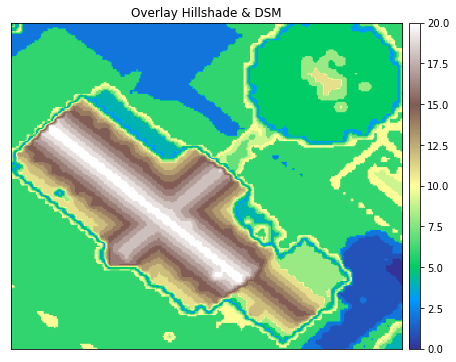

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))
ep.plot_bands(
    img_dms_raster[0], ax=ax, cmap="terrain", title="Overlay Hillshade & DSM",
)
ax.imshow(img_dms_raster[0], cmap="Greys", alpha=0.)
plt.show()

### 3D PLOT

In [21]:
zthree = img_dms_raster[0]
sh_0, sh_1 = zthree.shape
x, y = np.linspace(0, 1, sh_0), np.linspace(0, 1, sh_1)
fig = go.Figure(data=[go.Surface(z=zthree, x=x, y=y)])
fig.update_layout(title='House', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90), scene = {"aspectratio": {"x": 1, "y": 1, "z": 0.6}})
fig.show()

<img src="images/abbey.jpg" alt="abbey" width="600"/>

In [22]:
img_dms_raster.close()
img_dmt_raster.close()